In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

Files already extracted.
Total Classes Found: 20
Class distribution: {'F22': 40, 'H6k': 40, 'C5': 40, 'EA18G': 40, 'B52': 40, 'RQ4': 40, 'Tu160': 40, 'T50': 40, 'F35': 40, 'Rafal': 40, 'An225': 40, 'B1b': 40, 'EA6b': 40, 'F117': 40, 'E2d': 40, 'J10': 40, 'U2': 40, 'J20': 40, 'B2': 40, 'V22': 40}


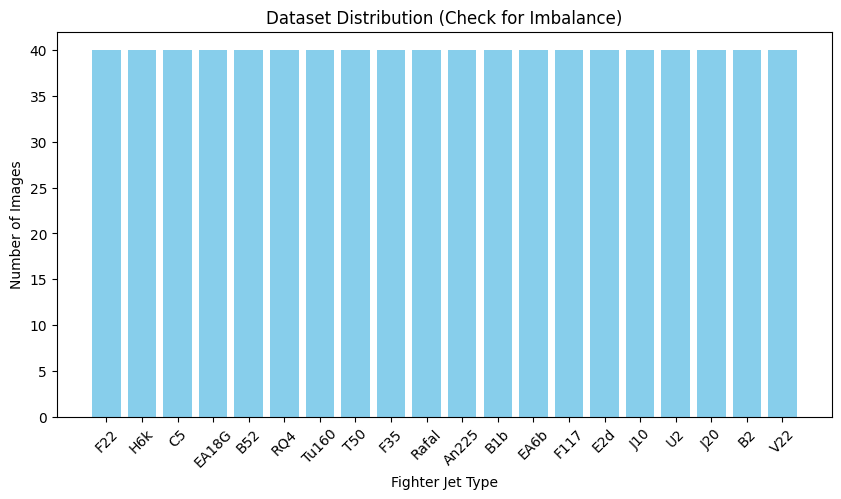

In [2]:
zip_path = '/content/Fighter planes Dataset-20260111T034915Z-3-001.zip'
extract_path = 'fighter_jets_data'

# Check if already extracted to avoid doing it twice
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete.")
else:
    print("Files already extracted.")

# 2. Count images per class
data_dir = extract_path
# Depending on how the zip was made, there might be a subfolder.
# Adjust 'base_dir' to point to the folder containing the aircraft names (e.g., F22, B52)
base_dir = extract_path

class_counts = {}

for root, dirs, files in os.walk(base_dir):
    # Only count folders that contain images
    if files:
        class_name = os.path.basename(root)
        # Filter for image files only to be safe
        image_count = len([f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if image_count > 0:
            class_counts[class_name] = image_count

# 3. Visualization
names = list(class_counts.keys())
values = list(class_counts.values())

print(f"Total Classes Found: {len(names)}")
print(f"Class distribution: {class_counts}")

plt.figure(figsize=(10, 5))
plt.bar(names, values, color='skyblue')
plt.xlabel('Fighter Jet Type')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Check for Imbalance)')
plt.xticks(rotation=45)
plt.show()

In [3]:
# 1. Define the Data Augmentation strategy
# We are adding rotation, width/height shifts, shear, zoom, and flips
# This effectively multiplies your training data diversity.
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Auto-adjusts colors for EfficientNet
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# 2. Setup the Data Loaders (Flow from directory)
# Make sure 'data_dir' matches the folder path where your 'F22', 'B52' folders are.
# If you used the previous code, it should be 'fighter_jets_data'
data_dir = os.path.join('fighter_jets_data', 'Fighter planes Dataset')
batch_size = 32
img_height = 224
img_width = 224

print("Loading Data for EfficientNet:")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

print("\nLoading Validation Data:")
# Note: Usually we don't augment validation data, just rescale it.
# But using the same generator with 'subset' is a quick way to split.
# For strict correctness, we'll rely on the split here, but typically validation data should be "clean".
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# 3. Verify Class Mappings
print(f"\nClass Indices: {train_generator.class_indices}")

Loading Data for EfficientNet:
Found 640 images belonging to 20 classes.

Loading Validation Data:
Found 160 images belonging to 20 classes.

Class Indices: {'An225': 0, 'B1b': 1, 'B2': 2, 'B52': 3, 'C5': 4, 'E2d': 5, 'EA18G': 6, 'EA6b': 7, 'F117': 8, 'F22': 9, 'F35': 10, 'H6k': 11, 'J10': 12, 'J20': 13, 'RQ4': 14, 'Rafal': 15, 'T50': 16, 'Tu160': 17, 'U2': 18, 'V22': 19}


In [4]:
# 1. Load the Pre-trained Base Model (MobileNetV2)
# include_top=False removes the final classification layer (which was for 1000 things)
# weights='imagenet' loads the pre-learned patterns
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 2. Unfreeze the WHOLE model
# Since we have so little data, we need the whole brain to adapt, not just the last layer.
base_model.trainable = True

# 3. Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x) # Increased to 256 for more learning power
x = Dropout(0.5)(x)
predictions = Dense(20, activation='softmax')(x)

# 4. Compile
model = Model(inputs=base_model.input, outputs=predictions)

# We use a very low learning rate (1e-4) to ensure we don't break the pre-trained weights
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train
print("Starting Training with EfficientNet...")
history = model.fit(
    train_generator,
    epochs=20, # Giving it enough time to learn
    validation_data=validation_generator
)

# 6. Save
model.save('fighter_jet_efficientnet.h5')
print("EfficientNet Model Saved.")

Starting Training with EfficientNet...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 252s 10s/step - accuracy: 0.0515 - loss: 3.1116 - val_accuracy: 0.1063 - val_loss: 2.9327
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 192s 9s/step - accuracy: 0.1116 - loss: 2.9322 - val_accuracy: 0.1375 - val_loss: 2.8602
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 187s 9s/step - accuracy: 0.1951 - loss: 2.7543 - val_accuracy: 0.2313 - val_loss: 2.7119
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.2374 - loss: 2.6295 - val_accuracy: 0.3375 - val_loss: 2.4720
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 193s 10s/step - accuracy: 0.3544 - loss: 2.4328 - val_accuracy: 0.4750 - val_loss: 2.1970
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 197s 10s/step - accuracy: 0.3829 - loss: 2.2485 - val_accuracy: 0.4875 - val_loss: 1.9176
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.5608 - loss: 1.8914 - val_accuracy: 0.5562 - val_loss: 1.6267
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 195s 10s/step - accuracy: 0.5947 - loss: 1.6425 - val_accuracy: 0.6750

EfficientNet Model Saved.


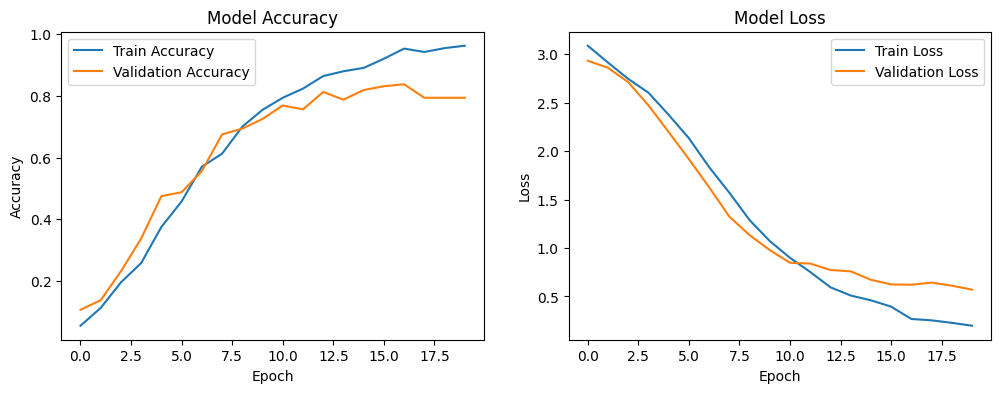

In [5]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()